<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Predicci%C3%B3n_de_da%C3%B1os_por_terremoto_Driven_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predictor de Richter: Modelización de los daños causados por terremotos**

*Jesús Roque Armas Martín - CEIABD*

# Descripción del problema


*  El objeto de esta actividad es participar en la competición de ofrecida de la web de DrivenData denominada: Richter's Predictor: [ Modeling Earthquake Damage](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/)

El conjunto de datos consiste principalmente en información sobre la estructura de los edificios y su propiedad legal.
Cada fila del dataset representa un edificio específico de la región afectada por el terremoto de Gorkha.
Hay 39 columnas en este conjunto de datos, donde la columna es un identificador único y aleatorio. Las 38 características restantes (que no son la etiqueta) se describen en la sección siguiente. Las variables categóricas se han ofuscado con caracteres ascii aleatorios en minúsculas. La aparición del mismo carácter en columnas distintas no implica el mismo valor original.

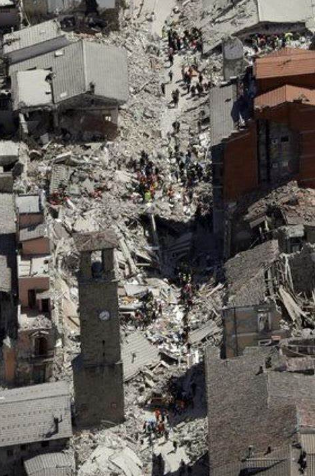

   [Derechos de la imagen](https://www.bing.com/ck/a?!&&p=b097f6d9d9416fdeJmltdHM9MTcxMjM2MTYwMCZpZ3VpZD0zMzY2ZGJhMi1mYThkLTYyMTItMGYwZi1jYjQ5ZmJhNjYzY2MmaW5zaWQ9NTIwMg&ptn=3&ver=2&hsh=3&fclid=3366dba2-fa8d-6212-0f0f-cb49fba663cc&psq=AP+News&u=a1aHR0cHM6Ly9hcG5ld3MuY29tLw&ntb=1)






Importación de las librerías necesarias

In [1]:
!pip install lazypredict

In [2]:
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib.colors import ListedColormap
import sklearn.neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.utils.multiclass import unique_labels

import lazypredict
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
import sklearn.externals
import joblib

# Importación del dataset

Importo los ficheros CSV, origen de los datos, descargados de driven data a mi repositorio de [GitHub](https://github.com/roquearmas/datasets/).

Posteriormente, uniré los valores de las x con sus etiquetas (y), ya que, en principio, vienen separadas. Luego descargaré ese dataset para inspeccionarlo, ya que parece ser bastante grande.

In [3]:
url_base ='https://github.com/roquearmas/datasets/releases/download/driven_Earthwuake/'

df_submission= pd.read_csv(url_base + 'submission_format.csv?raw=true')
df_train_X= pd.read_csv( url_base + 'train_values.csv?raw=true')
df_train_y= pd.read_csv( url_base + 'train_labels.csv?raw=true')
df_test_X= pd.read_csv ( url_base + 'test_values.csv?raw=true')

df_train_X.head()


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_submission.head()

,building_id,damage_grade
0,300051,1
1,99355,1
2,890251,1
3,745817,1
4,421793,1


In [ ]:
df_train_y.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [ ]:
df_test_X.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


Uno los dataframes de X e y de train para obtener uno solo

In [4]:
df_train = pd.merge(df_train_X,df_train_y,on=['building_id'])

df_train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


Descargo el dataframe obtenido para inspeccionarlo

In [5]:
with open('datos_train.csv', 'w') as f:
  df_train.to_csv(f,  index = False)

files.download('datos_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Verificar si hay datos nulos en el dataset

In [6]:
df_train.loc[df_train.isnull().any(axis=1)]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade


Se comprueba que no hay un solo dato nulo en el dataset generado.

# Selección de filas

Elijo la zona 20 porque tiene un número suficiente de registros para el estudio y los datos, entre los distintos valores de y, están más balanceados que en ninguna zona otra geográfica.

In [7]:
df_train_filtrado = df_train[df_train['geo_level_1_id'] == 20]

Después de varias pruebas, decido truncar los datos, para balancearlos totalmente, eligiendo 2.000 para cada valor de la etiqueta (1,2,ó 3)

In [8]:
# Filtrar 2000 filas para cada valor de etiqueta
df_train_reducido1 = df_train_filtrado[df_train_filtrado['damage_grade'] == 1].head(2000)
df_train_reducido2 = df_train_filtrado[df_train_filtrado['damage_grade'] == 2].head(2000)
df_train_reducido3 = df_train_filtrado[df_train_filtrado['damage_grade'] == 3].head(2000)

# Concatenar los resultados en un nuevo dataframe
df_filtrado_reducido = pd.concat([df_train_reducido1, df_train_reducido2, df_train_reducido3])

# Transformación de datos
Comienzo con la transformación de los tipos de datos de las columnas categóricas, que tienen valores con carácteres aleatorios, en numéricos

In [9]:
# hago copia de los datasets sin transformar
df_train_trans= df_filtrado_reducido.copy()
#df_train_trans= df_train.copy()
df_test_trans = df_test_X.copy()
# conocer los valores categóricos de cada columna
print('land_surface_condition - Valores:', df_train_trans['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_train_trans['foundation_type'].unique())
print('roof_type              - Valores:', df_train_trans['roof_type'].unique())
print('ground_floor_type      - Valores:', df_train_trans['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_train_trans['other_floor_type'].unique())
print('position               - Valores:', df_train_trans['position'].unique())
print('plan_configuration     - Valores:', df_train_trans['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_train_trans['legal_ownership_status'].unique())

land_surface_condition - Valores: ['t' 'n' 'o']
foundation_type        - Valores: ['w' 'i' 'h' 'r' 'u']
roof_type              - Valores: ['q' 'x' 'n']
ground_floor_type      - Valores: ['v' 'f' 'z' 'x' 'm']
other_floor_type       - Valores: ['x' 'j' 'q' 's']
position               - Valores: ['s' 't' 'j' 'o']
plan_configuration     - Valores: ['u' 'd' 'a' 'n' 'q' 'o' 's' 'c' 'm']
legal_ownership_status - Valores: ['v' 'a' 'r' 'w']


Asigno valores numéricos a cada uno de los valores categóricos de cada columna

In [10]:
df_train_trans["land_surface_condition"].replace(['t', 'o', 'n'],[0, 1, 2], inplace=True)
df_train_trans["foundation_type"].replace(['r', 'w', 'i', 'u', 'h'],[0, 1, 2, 3, 4], inplace=True)
df_train_trans["roof_type"].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df_train_trans["ground_floor_type"].replace(['f', 'x', 'v', 'z', 'm',],[0, 1, 2, 3, 4], inplace=True)
df_train_trans["other_floor_type"].replace(['q', 'x', 'j', 's'],[0, 1, 2, 3], inplace=True)
df_train_trans["position"].replace(['t', 's', 'j', 'o'],[0, 1, 2, 3], inplace=True)
df_train_trans["plan_configuration"].replace(['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df_train_trans["legal_ownership_status"].replace(['v', 'a', 'r', 'w'],[0, 1, 2, 3], inplace=True)

In [ ]:
df_train_trans.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
7,475515,20,323,12236,2,0,8,6,0,1,...,0,0,0,0,0,0,0,0,0,1
31,16485,20,953,6651,2,15,13,5,0,1,...,0,0,0,0,0,0,0,0,0,2
46,132583,20,261,11561,2,15,7,5,2,1,...,0,0,0,0,0,0,0,0,0,2
50,871517,20,261,2189,2,10,7,5,0,1,...,0,0,0,0,0,0,0,0,0,2
76,425720,20,136,4769,2,0,5,7,0,1,...,0,0,0,0,0,0,0,0,0,1


También para el dataframe de test

In [11]:
df_test_trans["land_surface_condition"].replace(['t', 'o', 'n'],[0, 1, 2], inplace=True)
df_test_trans["foundation_type"].replace(['r', 'w', 'i', 'u', 'h'],[0, 1, 2, 3, 4], inplace=True)
df_test_trans["roof_type"].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df_test_trans["ground_floor_type"].replace(['f', 'x', 'v', 'z', 'm',],[0, 1, 2, 3, 4], inplace=True)
df_test_trans["other_floor_type"].replace(['q', 'x', 'j', 's'],[0, 1, 2, 3], inplace=True)
df_test_trans["position"].replace(['t', 's', 'j', 'o'],[0, 1, 2, 3], inplace=True)
df_test_trans["plan_configuration"].replace(['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df_test_trans["legal_ownership_status"].replace(['v', 'a', 'r', 'w'],[0, 1, 2, 3], inplace=True)

Comprobación. Nuevos valores de las columnas anteriormente categóricas

In [12]:
print('land_surface_condition - Valores:', df_train_trans['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_train_trans['foundation_type'].unique())
print('roof_type              - Valores:', df_train_trans['roof_type'].unique())
print('ground_floor_type      - Valores:', df_train_trans['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_train_trans['other_floor_type'].unique())
print('position               - Valores:', df_train_trans['position'].unique())
print('plan_configuration     - Valores:', df_train_trans['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_train_trans['legal_ownership_status'].unique())

land_surface_condition - Valores: [0 2 1]
foundation_type        - Valores: [1 2 4 0 3]
roof_type              - Valores: [1 2 0]
ground_floor_type      - Valores: [2 0 3 1 4]
other_floor_type       - Valores: [1 2 0 3]
position               - Valores: [1 0 2 3]
plan_configuration     - Valores: [1 0 6 7 3 9 2 5 4]
legal_ownership_status - Valores: [0 1 2 3]


In [ ]:
print('land_surface_condition - Valores:', df_test_trans['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_test_trans['foundation_type'].unique())
print('roof_type              - Valores:', df_test_trans['roof_type'].unique())
print('ground_floor_type      - Valores:', df_test_trans['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_test_trans['other_floor_type'].unique())
print('position               - Valores:', df_test_trans['position'].unique())
print('plan_configuration     - Valores:', df_test_trans['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_test_trans['legal_ownership_status'].unique())

land_surface_condition - Valores: [0 2 1]
foundation_type        - Valores: [0 1 3 4 2]
roof_type              - Valores: [0 2 1]
ground_floor_type      - Valores: [0 2 1 4 3]
other_floor_type       - Valores: [0 2 1 3]
position               - Valores: [1 0 2 3]
plan_configuration     - Valores: [0 1 3 6 5 4 2 9 8 7]
legal_ownership_status - Valores: [0 1 3 2]


Coprobamos los tipos de datos, después de las transformaciones

In [ ]:
df_train_trans.dtypes

building_id                               int64
geo_level_1_id                            int64
geo_level_2_id                            int64
geo_level_3_id                            int64
count_floors_pre_eq                       int64
age                                       int64
area_percentage                           int64
height_percentage                         int64
land_surface_condition                    int64
foundation_type                           int64
roof_type                                 int64
ground_floor_type                         int64
other_floor_type                          int64
position                                  int64
plan_configuration                        int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick  

**Escalamiento**

Escalo todas las columnas , ya que todas tienen valores numéricos.

In [13]:
Scaler=MinMaxScaler()

datos_escalados=Scaler.fit_transform(df_train_trans)
df_train_escalados=pd.DataFrame(datos_escalados, columns=df_train_trans.columns)

datos_escalados = Scaler.fit_transform(df_test_trans)
df_test_escalados = pd.DataFrame(datos_escalados, columns=df_test_trans.columns)

In [ ]:
df_train_escalados.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,0.76,0.20,0.34,0.97,0.12,0.03,0.05,0.10,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,0.03,0.27,0.63,0.22,0.12,0.01,0.07,0.17,0.50,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
2,0.09,0.70,0.25,0.71,0.12,0.01,0.04,0.10,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0.56,0.73,0.29,0.85,0.12,0.01,0.05,0.10,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
4,0.19,0.37,0.09,0.12,0.25,0.03,0.07,0.23,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [ ]:
df_test_escalados.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0.28,0.57,0.42,0.90,0.29,0.02,0.07,0.13,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.09,0.20,0.10,0.95,0.14,0.03,0.13,0.10,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.85,0.73,0.01,0.80,0.14,0.01,0.03,0.10,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.71,0.87,0.03,0.05,0.00,0.00,0.20,0.03,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.40,0.57,0.20,0.63,0.29,0.02,0.08,0.17,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


***Separar datos de train y validación***

Elijo un 80% para train y un 20% para validación. Hay que separar los datos de manera estratificada, para que haya datos de todas las etiquetas en los dos conjuntos de datos

In [14]:
df_train_ult, df_valid_ult = train_test_split(df_train_escalados, test_size=0.1, stratify=df_train_escalados['damage_grade'], random_state=42)

Obtengo la distribución de datos en cada una de las clases, para los entornos de entrenamiento y validación, respectivamente.

In [15]:
print('Datos de train, distribución de las clases')
print('------------------------------------------')
print(df_train_ult['damage_grade'].value_counts())
print('------------------------------------------')
print('Porcentajes')
print('------------------------------------------')
porcentajes=(df_train_ult['damage_grade'].value_counts()/len(df_train_ult))*100
porcentaje_form= porcentajes.apply(lambda x: "{:.2f}%".format(x))
print(porcentaje_form)

Datos de train, distribución de las clases
------------------------------------------
damage_grade
1.00    1800
0.00    1800
0.50    1800
Name: count, dtype: int64
------------------------------------------
Porcentajes
------------------------------------------
damage_grade
1.00    33.33%
0.00    33.33%
0.50    33.33%
Name: count, dtype: object


In [16]:
print('Datos de validation, distribución de las clases')
print('-----------------------------------------------')
print(df_valid_ult['damage_grade'].value_counts())

porcentajes=(df_valid_ult['damage_grade'].value_counts()/len(df_valid_ult))*100
porcentaje_form= porcentajes.apply(lambda x: "{:.2f}%".format(x))
print('------------------------------------------')
print('Porcentajes')
print('------------------------------------------')
print (porcentaje_form)

Datos de validation, distribución de las clases
-----------------------------------------------
damage_grade
0.00    200
0.50    200
1.00    200
Name: count, dtype: int64
------------------------------------------
Porcentajes
------------------------------------------
damage_grade
0.00    33.33%
0.50    33.33%
1.00    33.33%
Name: count, dtype: object


*Se observa que los porcentajes son idéndticos para los dos conjuntos de datos y totalmente balanceados entre las tres etiquetas*

# Reducción de características

Las dos primeras columnas no deberían formar parte de los cálculos, puesto que el id del edificio no es relevante y el área geográfica siempre va a ser la misma en nuestro dataset.

In [17]:
df_estudio_train = df_train_ult.iloc[:,2:]
df_estudio_val   = df_valid_ult.iloc[:,2:]
df_estudio_test  = df_test_escalados.iloc[:,2:]

***Dendograma***

Distancia Media	  24.50


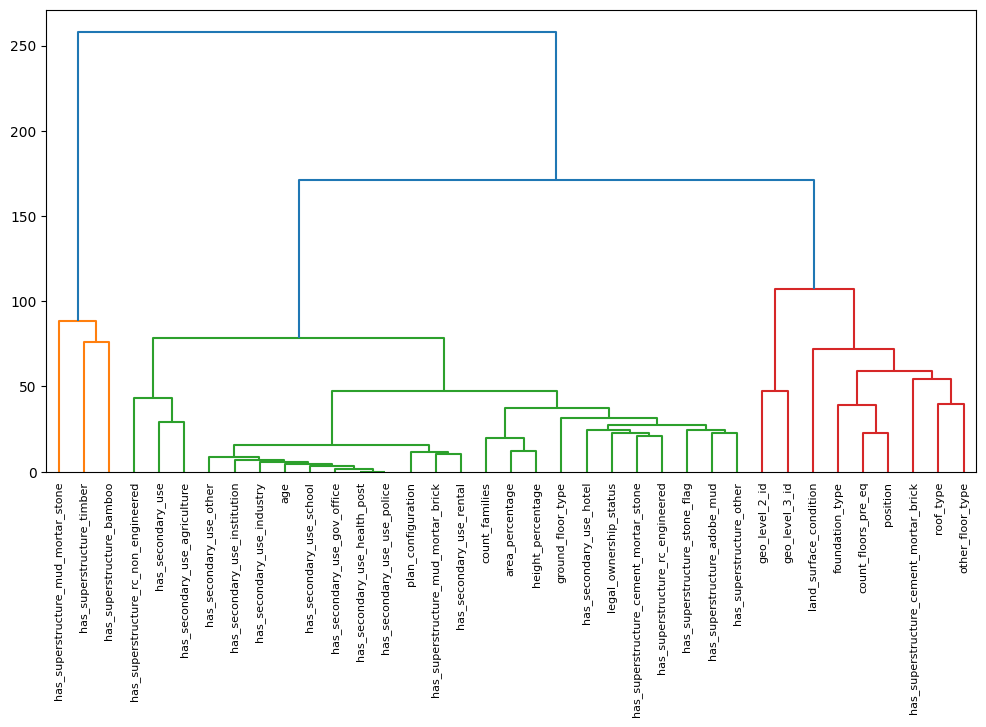

In [18]:
## Clustering jerárquico
# 1. Obtener la matriz de distancia entre todos los elementos

dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(df_estudio_train.drop('damage_grade', axis=1).T)
#D=dist.pairwise(X_train.T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Construimos el dendograma
from scipy import cluster
plt.figure(figsize=(12, 6))
# Seleccionamos como distancia intercluster el vecino más alejado (complete)
clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=160,labels=df_estudio_train.drop('damage_grade', axis=1).columns.to_list(),leaf_rotation=90)
#cluster.hierarchy.dendrogram(clusters, color_threshold=160,labels=X_train.columns.to_list(),leaf_rotation=90)
plt.show()

Obtenemos el grupo/cluster al que pertenece cada observación/muestra/fila del dataset

In [19]:
threshold = 160 # ad-hoc, es decir por criterio de la persona que está resolviendo el problema
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')

# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 3


array([3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 1, 2, 2, 2, 3, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Se nos agrupan las columnas en 4 clusters
Ahora puedo aplicar PCA

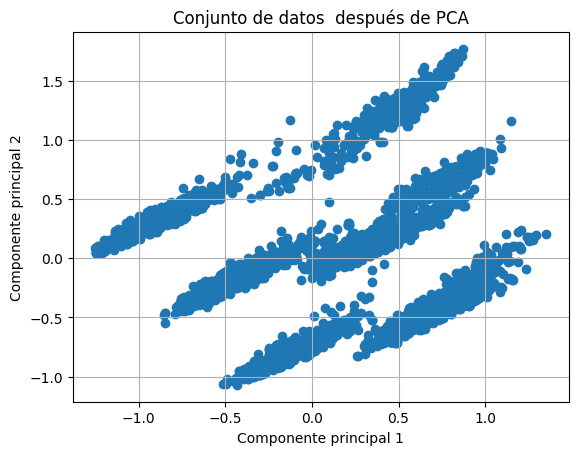

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Reducimos la dimensionalidad de los datos (a dos dimensiones)
'''pca = PCA(n_components = 2)
X_pca = df_estudio_train.drop('damage_grade', axis=1)
y_pca = df_estudio_train['damage_grade'].astype('int')

X_pca = pca.fit_transform(X_pca)
X_pca
'''
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_train_ult)

# Graficar los datos reducidos a 2 dimensiones
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("Conjunto de datos  después de PCA")
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid(True)
plt.show()

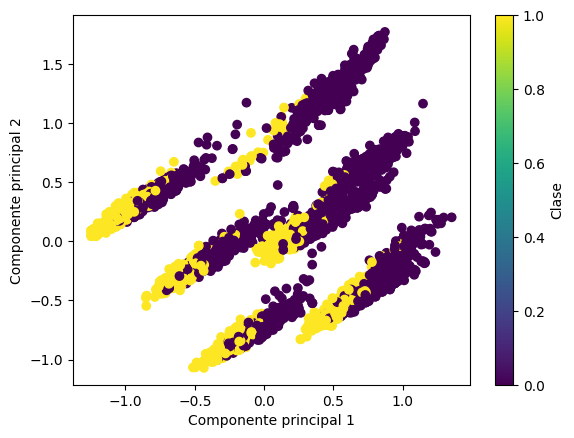

In [ ]:
# Visualizar los datos en el nuevo espacio de características PCA
y_pca = df_train_ult['damage_grade'].astype('int')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap='viridis')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Clase')
plt.show()


**Matriz decorrelación**

<Axes: >

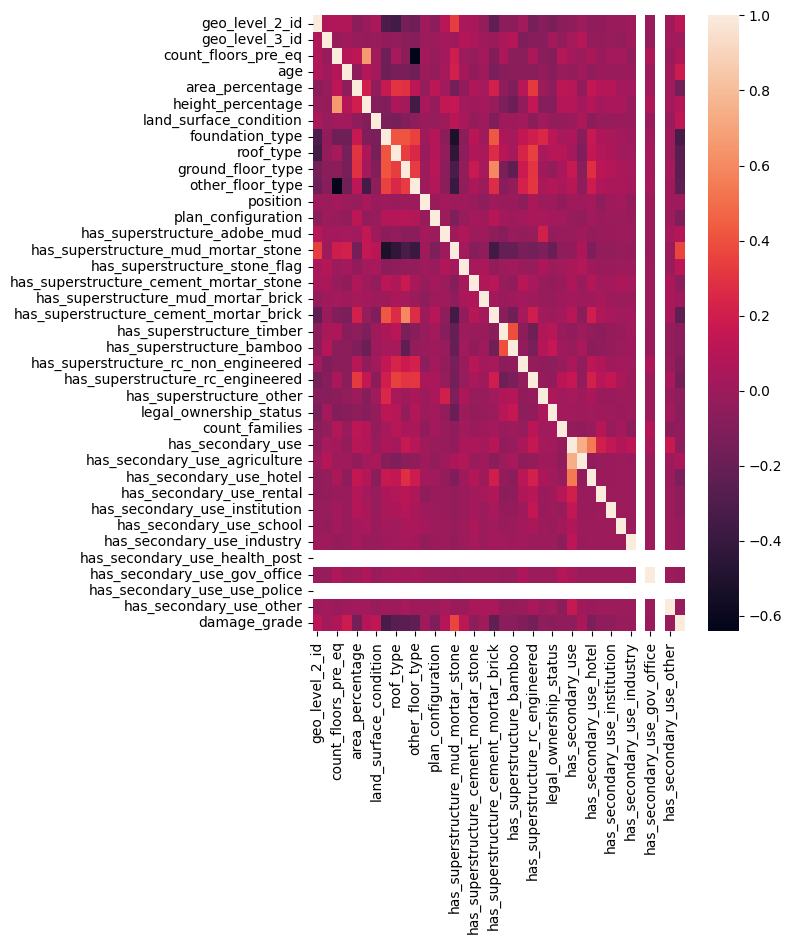

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
sns.heatmap(df_estudio_train.corr())

Expresada en una sola columna

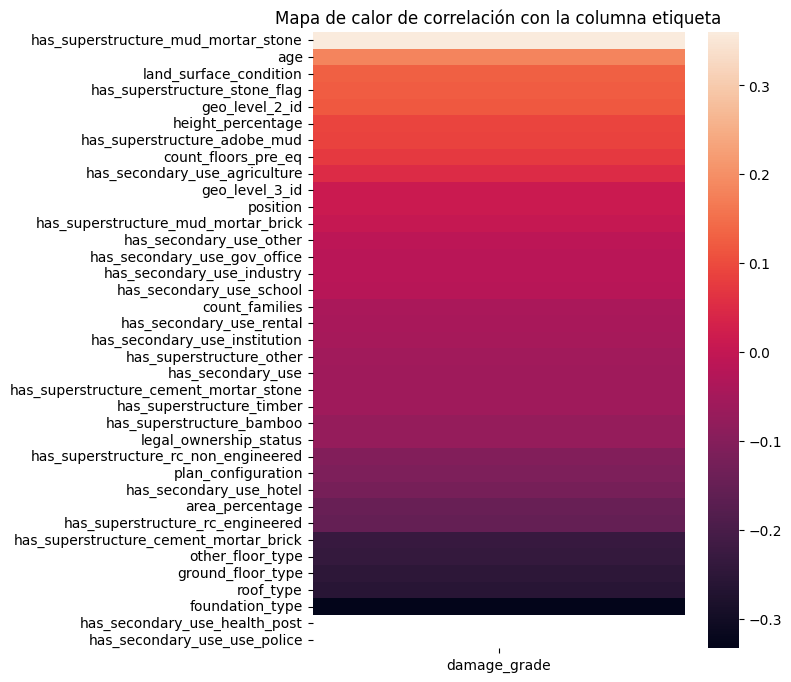

In [ ]:
DEPOSIT_COLUMN = 'damage_grade'
correlation_matrix = df_estudio_train.corr()
def plot_deposit_correlations(data):
    # Aísla la columna de deposito y visualiza todas las demás en función de ella
    deposit_correlation_column = pd.DataFrame(correlation_matrix[DEPOSIT_COLUMN].drop(DEPOSIT_COLUMN))
    deposit_correlation_column = deposit_correlation_column.sort_values(by=DEPOSIT_COLUMN, ascending=False)
    sns.heatmap(deposit_correlation_column)
    plt.title('Mapa de calor de correlación con la columna etiqueta')

plot_deposit_correlations(df_estudio_train)

In [20]:
columnas_irrelevantes      = ['damage_grade','has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post']
columnas_irrelevantes_test = ['has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post']
X_train = df_estudio_train.drop(columnas_irrelevantes, axis=1)
y_train = df_estudio_train['damage_grade'].replace({0.0:1,0.5 :2, 1.0:3})
X_val   = df_estudio_val.drop(columnas_irrelevantes, axis=1)
y_val   = df_estudio_val['damage_grade'].replace({0.0:1,0.5 :2, 1.0:3})
X_test  = df_estudio_test.drop(columnas_irrelevantes_test, axis=1)
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train , y_train)

LogisticRegression(max_iter=10000)

Muestro los coeficientes de regresión obtenidos

In [ ]:
print(model_lr.coef_)

[[ 0.29041692  0.03403034  0.91472588 -2.86958284  0.70635707 -1.27063137
  -0.37845204  0.78937951  0.17490345  0.41415129  0.65900645 -0.04767335
   0.99588109 -0.51014674 -0.59484294 -1.2612884   0.09572591 -0.1365734
   0.14033077 -0.08061872  0.14421886  0.15952184  0.57320177  0.37925655
   0.08895111 -0.19929416  0.26751424 -0.42051563  0.05126317  0.09918668
   0.55021117 -0.20476966 -0.02408169 -0.05830159]
 [-0.08817138  0.01860448 -0.21232966  1.12904078  0.31435605 -0.05001912
   0.16305024 -0.14682883  0.09642106 -0.03900993 -0.47493261 -0.26354787
  -0.23990769  0.08239134  0.15759923  0.26788466 -0.22096875 -0.20919647
   0.59494643  0.12915943  0.02554125 -0.16490934 -0.06880628 -0.67631857
  -0.05075113  1.07317883  0.34028155 -0.07154228  0.147371    0.15594552
  -0.25939072  0.33392655 -0.16590569  0.0097182 ]
 [-0.20224554 -0.05263482 -0.70239622  1.74054206 -1.02071312  1.32065049
   0.2154018  -0.64255068 -0.27132451 -0.37514136 -0.18407384  0.31122122
  -0.755973

Ordenar los coeficientes por relevancia, de menos a más

In [ ]:
orden = np.argsort(np.abs(model_lr.coef_))
orden_array = np.array(orden)
print(X_train.columns.take(orden))

Index(['has_secondary_use_industry', 'geo_level_3_id', 'position',
       'has_secondary_use_hotel', 'has_secondary_use_other',
       'has_superstructure_timber', 'legal_ownership_status',
       'has_superstructure_cement_mortar_stone', 'has_secondary_use_rental',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_bamboo',
       'has_superstructure_rc_non_engineered', 'roof_type', 'count_families',
       'has_secondary_use_school', 'has_secondary_use', 'geo_level_2_id',
       'land_surface_condition', 'has_superstructure_other',
       'ground_floor_type', 'has_secondary_use_agriculture',
       'has_superstructure_adobe_mud', 'has_secondary_use_institution',
       'has_superstructure_rc_engineered',
       'has_superstructure_mud_mortar_stone', 'other_floor_type',
       'area_percentage', 'foundation_type', 'count_floors_pre_eq',
       'plan_configuration', 'has_superstructure_stone_flag',
       'height_percentag

Evalúo los resultados mediante el mismo coeficiente que utiliza driven data, micro averaged F1 score

In [ ]:
preds_train = model_lr.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_train, average='micro'))


F1_score del modelo en validation: 0.5266666666666666


Pruebo el modelo con test para subir el primer fichero

In [ ]:
y_pred_lr = model_lr.predict(X_test)
np.unique(y_pred_lr)

array([1., 2., 3.])

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          titleSup=None):
    # y_true : dataframe -> Los valores de las clases que son ciertos (test)
    # y_pred : ndarray   -> Los valores calculados de las clases después de realizar la predicción
    # class  : ndarray   -> Los nombres de las clases/valores objetivos

    if not title:
        if normalize:
            title = 'Matriz de Confusión normalizada'
        else:
            title = 'Matriz de Confusión, no normalizada'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(type(y_true))
    print(type(y_pred))
    classes = classes[unique_labels(y_true.astype(int), y_pred.astype(int))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión normalizada")
    else:
        print('Matriz de Confusión, no normalizada')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.suptitle(titleSup, fontsize=16, y=1, ha='center')
    return ax

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[1158  307  335]
 [ 577  498  725]
 [ 338  373 1089]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.64333333 0.17055556 0.18611111]
 [0.32055556 0.27666667 0.40277778]
 [0.18777778 0.20722222 0.605     ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

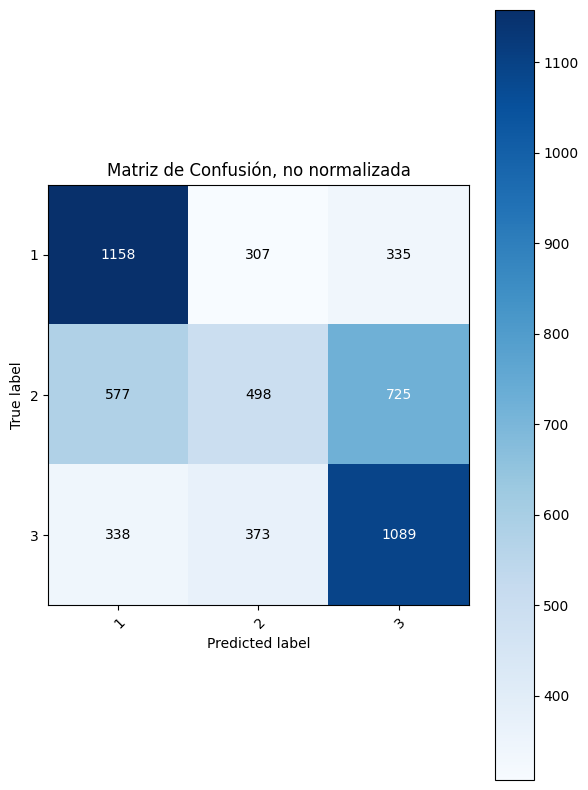

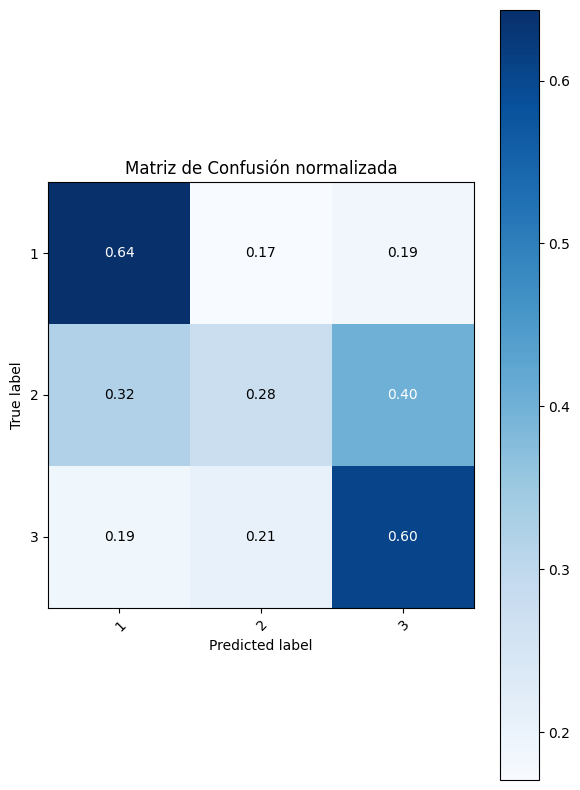

In [ ]:

# Realizar predicciones en el conjunto de prueba
y_pred = model_lr.predict(X_train)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(y_train, y_pred,classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_train, y_pred,classes= np.array(['0','1','2','3']) , normalize=True)

In [22]:
def subir_fichero (y_pred, nombre_fichero):
  submit = df_submission.copy()
  resultado = np.rint( y_pred )
  resultado = resultado.astype(int)
  submit['damage_grade'] = resultado
  submit.to_csv(nombre_fichero,index=False)
  files.download(nombre_fichero)

In [ ]:
subir_fichero (y_pred_lr,'preds_lr.csv')


**Linear Regression Con Cross Validation**

In [ ]:
X_train_cv= X_train.copy() #al poner shuffle =True desordenaba el dataset, hago copia para que no lo desordene
y_train_cv= y_train.copy()
cv = KFold(n_splits = 20, shuffle = True) #al poner shuffle =True desordenaba el dataset
cv_f1scores=[]
for i in range(2,10):
  for cv_train, cv_test in cv.split(X_train):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_cv.iloc[cv_train]
    cv_train_y = y_train_cv.iloc[cv_train]

    # vamos entrenando los modelos
    model_lr.fit(cv_train_x, cv_train_y)

    #guardo el predict de cada modelo
    y_pred = model_lr.predict(X_train.iloc[cv_test])
    #y_np=np.zeros(len(cv_test))
    y_np=y_train.iloc[cv_test].values

    cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

    cv_f1scores.append(cv_f1score)
  #guardo la media de los f1_Scores, para cada split
  media_scores=sum(cv_f1scores)/len(cv_f1scores)

  #recorro los clasificadores y voy mostrando la precision por cada uno de ellos
  print ("F1_Score medio: = %.4f para %i splits" %  (media_scores,i ))

F1_Score medio: = 0.5024 para 2 splits
F1_Score medio: = 0.5007 para 3 splits
F1_Score medio: = 0.5004 para 4 splits
F1_Score medio: = 0.5009 para 5 splits
F1_Score medio: = 0.5008 para 6 splits
F1_Score medio: = 0.5010 para 7 splits
F1_Score medio: = 0.5010 para 8 splits
F1_Score medio: = 0.5007 para 9 splits


In [ ]:
X_train_cv= X_train.copy() #al poner shuffle =True desordenaba el dataset, hago copia para que no lo desordene
y_train_cv= y_train.copy()
cv = KFold(n_splits = 8, shuffle = True) #al poner shuffle =True desordena el dataset
cv_f1scores=[]

for cv_train, cv_test in cv.split(X_train):
  # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
  cv_train_x = X_train_cv.iloc[cv_train]
  cv_train_y = y_train_cv.iloc[cv_train]

  # vamos entrenando los modelos
  model_lr.fit(cv_train_x, cv_train_y)

  #guardo el predict de cada modelo
  y_pred = model_lr.predict(X_train.iloc[cv_test])
  #y_np=np.zeros(len(cv_test))
  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)
#guardo la media de los f1_Scores, para cada split
media_scores=sum(cv_f1scores)/len(cv_f1scores)

#recorro los clasificadores y voy mostrando la precision por cada uno de ellos
print ("F1_Score medio: = %.4f" %  (media_scores ))

F1_Score medio: = 0.4993


Hago la predicción del modelo entrenado con cross validation,sobre test

In [ ]:
y_pred_lr = model_lr.predict(X_test)


In [ ]:
subir_fichero(y_pred,'lr_cv_RAM.csv')

Estimación de los mejores hiperparámetros con GridSearch

In [ ]:
# Definir rango de parámetros

parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_lr = GridSearchCV(model_lr, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_lr.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = GS_lr.best_params_
print(mejores_params)

{'class_weight': 'balanced', 'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2'}


In [ ]:
model_lr_gs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_gs.fit(X_train , y_train)


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

Predicciones del modelo entrenado con las recomendaciones de Grid Search

F1_score del modelo en validation: 0.5233333333333333
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[136  29  35]
 [ 65  56  79]
 [ 33  45 122]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.68  0.145 0.175]
 [0.325 0.28  0.395]
 [0.165 0.225 0.61 ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

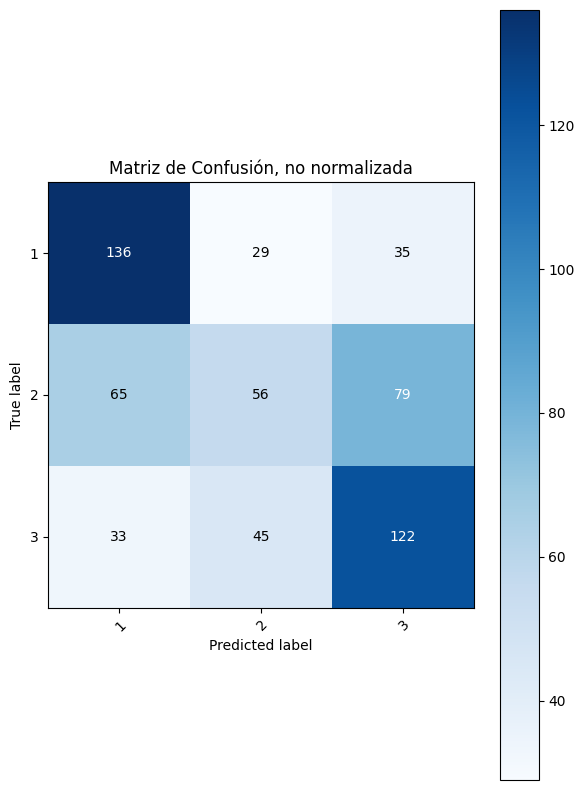

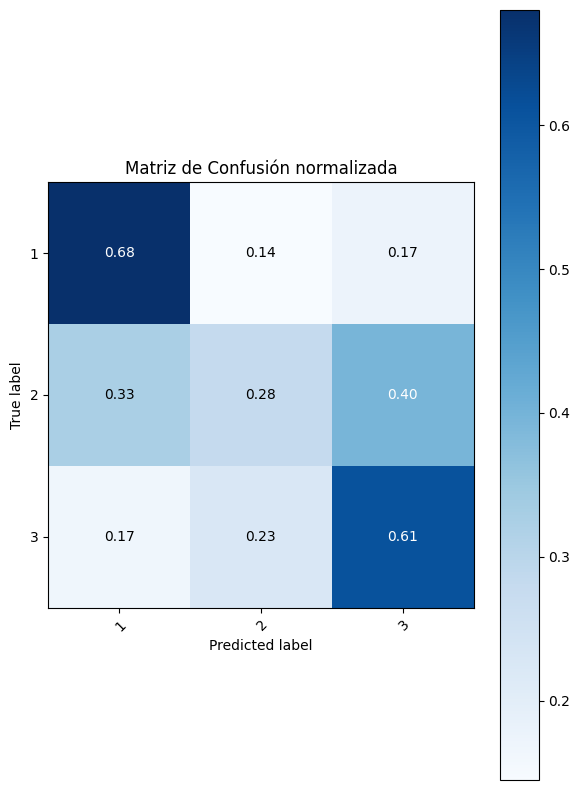

In [ ]:
preds_val = model_lr_gs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, preds_val)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=True)

In [ ]:
y_pred= model_lr_gs.predict(X_test)


In [ ]:
subir_fichero(y_pred,'lr_GS_RAM.csv')

Aplicacion de Random Search a Logistic Regression

In [ ]:
# Definir rand de parámetros
parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
RS_lr = RandomizedSearchCV(model_lr, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_lr.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = RS_lr.best_params_
print(mejores_params)

{'penalty': 'l2', 'multi_class': 'ovr', 'fit_intercept': False, 'class_weight': 'balanced'}


F1_score del modelo en validation: 0.52
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[137  26  37]
 [ 66  51  83]
 [ 33  43 124]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.685 0.13  0.185]
 [0.33  0.255 0.415]
 [0.165 0.215 0.62 ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

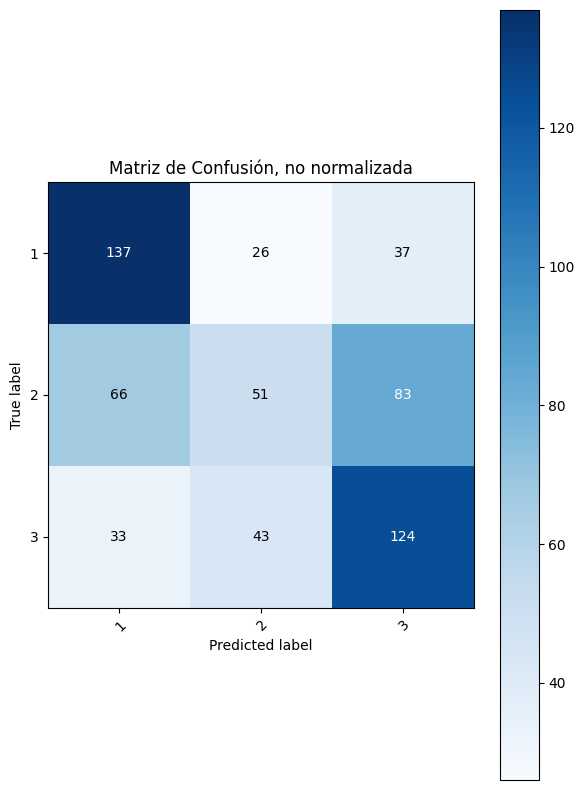

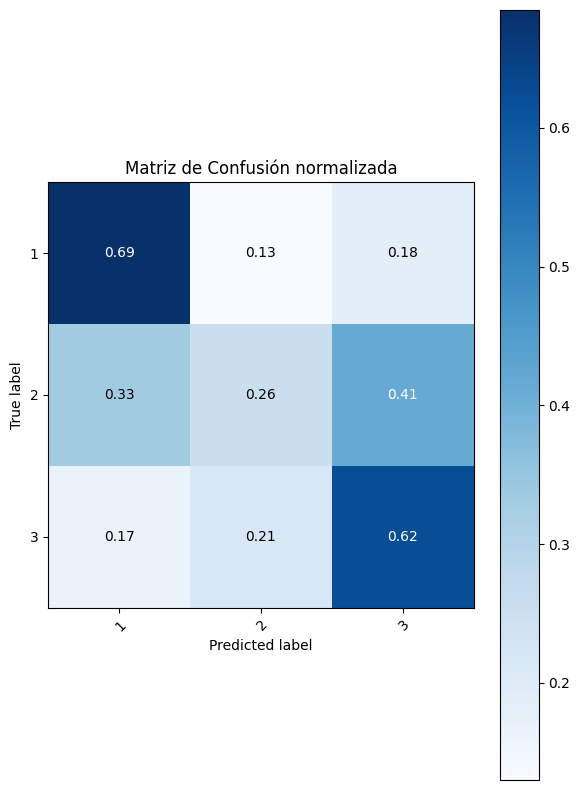

In [ ]:
model_lr_rs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_rs.fit(X_train , y_train)
preds_val = model_lr_rs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, preds_val)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=True)

In [ ]:
y_pred= model_lr_rs.predict(df_test)
subir_fichero(y_pred,'lr_RS_RAM.csv')

# Reducción de características

Algunas columnas, según el dendograma, pueden agruparse para simplificar el dataset.
Voy a generar la media de los cuatro grupos que arroja el dendograma, por separado, obteniendo datasets con cuatro columnas, más la columna etiqueta

In [ ]:
X_train.columns

Index(['geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_othe

Voy a reducir las columnas de las matrices, haciendo una media de valores para cada grupo que mostró el dendograma, y generando un nuevo dataset de 4 columnas con esos valores.

In [23]:
columnas_grupo1=['area_percentage','count_families','age','has_secondary_use_school','has_secondary_use_institution','has_secondary_use_industry','has_secondary_use_other','plan_configuration',
                 'has_superstructure_mud_mortar_brick','has_secondary_use_rental','count_floors_pre_eq','height_percentage','has_superstructure_rc_non_engineered','ground_floor_type','has_secondary_use_hotel',
                 'legal_ownership_status','has_superstructure_cement_mortar_stone','has_superstructure_rc_engineered','has_superstructure_stone_flag','has_superstructure_adobe_mud','has_superstructure_other']
columnas_grupo2=['has_superstructure_cement_mortar_brick','has_secondary_use','has_secondary_use_agriculture','land_surface_condition','foundation_type','position','roof_type','other_floor_type']
columnas_grupo3=['geo_level_2_id','geo_level_3_id']
columnas_grupo4=['has_superstructure_mud_mortar_stone','has_superstructure_timber','has_superstructure_bamboo']

media_train1=X_train[columnas_grupo1].mean(axis=1)
media_train2=X_train[columnas_grupo2].mean(axis=1)
media_train3=X_train[columnas_grupo3].mean(axis=1)
media_train4=X_train[columnas_grupo4].mean(axis=1)

media_val1=X_val[columnas_grupo1].mean(axis=1)
media_val2=X_val[columnas_grupo2].mean(axis=1)
media_val3=X_val[columnas_grupo3].mean(axis=1)
media_val4=X_val[columnas_grupo4].mean(axis=1)

media_test1=X_test[columnas_grupo1].mean(axis=1)
media_test2=X_test[columnas_grupo2].mean(axis=1)
media_test3=X_test[columnas_grupo3].mean(axis=1)
media_test4=X_test[columnas_grupo4].mean(axis=1)

X_red_train = pd.DataFrame({'grupo1':media_train1,'grupo2': media_train2,'grupo3': media_train3,'grupo4': media_train4}) # X reducida para train
X_red_val   = pd.DataFrame({'grupo1':media_val1,  'grupo2': media_val2,  'grupo3': media_val3,  'grupo4': media_val4})   # X reducida para validation
X_red_test  = pd.DataFrame({'grupo1':media_test1, 'grupo2': media_test2, 'grupo3': media_test3, 'grupo4': media_test4})  # X reducida para test

# SVM - Máquina de Vector de Soporte

In [ ]:
model_svc = SVC(kernel='linear', C=10000)
model_svc.fit(X_red_train, y_train)

SVC(C=10000, kernel='linear')

Método para evaluar el modelo

In [24]:
def evaluar_modelo (modelo):
  preds_val  = modelo.predict(X_red_val)
  preds_test = modelo.predict(X_red_test)

  print(classification_report(preds_val, y_val))
  print('Accuracy en validation:', metrics.accuracy_score(preds_val, y_val))
  print('F1_score en validation:', metrics.f1_score( y_val,preds_val, average='micro'))
  return preds_test, preds_val

              precision    recall  f1-score   support

         1.0       0.37      0.54      0.44       136
         2.0       0.18      0.46      0.26        80
         3.0       0.79      0.41      0.54       384

    accuracy                           0.45       600
   macro avg       0.45      0.47      0.41       600
weighted avg       0.61      0.45      0.48       600

Accuracy en validation: 0.44666666666666666
F1_score en validation: 0.44666666666666666
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[ 74  19 107]
 [ 43  37 120]
 [ 19  24 157]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.37  0.095 0.535]
 [0.215 0.185 0.6  ]
 [0.095 0.12  0.785]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

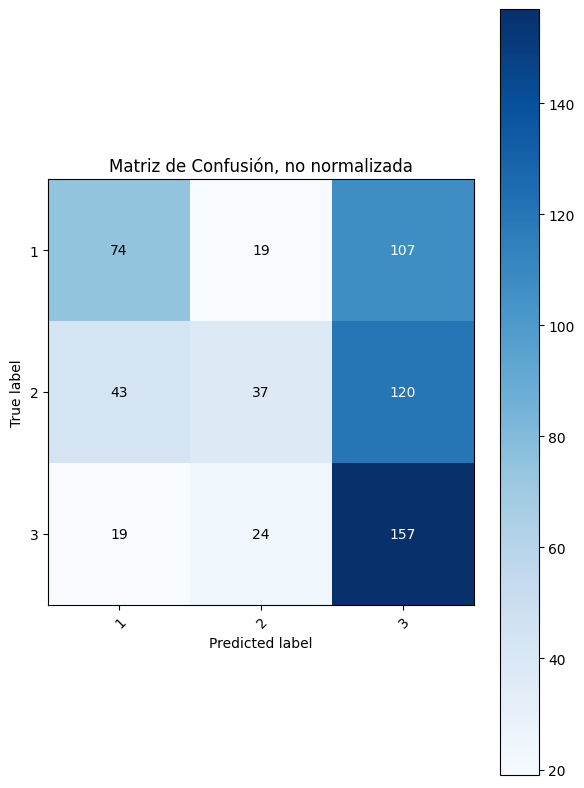

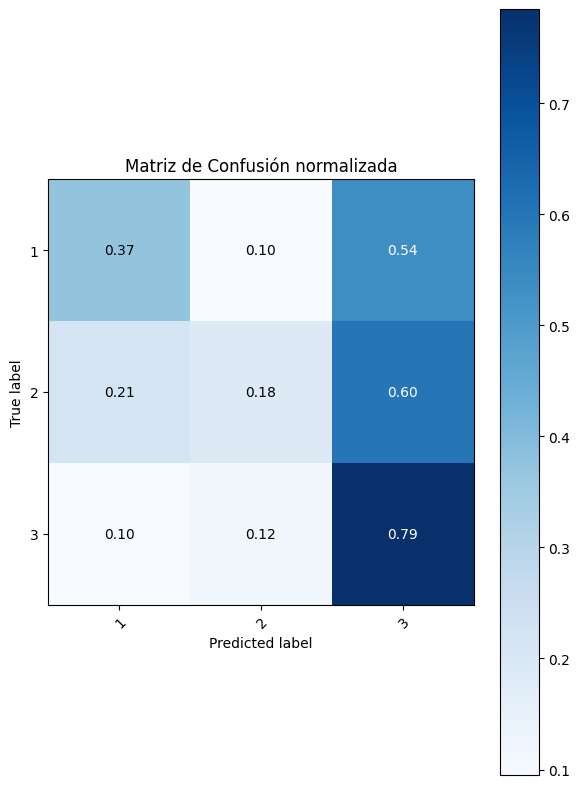

In [ ]:
y_test , pred_val= evaluar_modelo (model_svc)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

In [ ]:
subir_fichero(y_test,'SVC_RAM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVC con Cross Validation

In [ ]:
X_red_val.head()

,grupo1,grupo2,grupo3,grupo4
17166,0.12,0.35,0.15,0.00
4272,0.15,0.44,0.08,0.00
8615,0.07,0.32,0.58,1.00
351,0.03,0.22,0.17,0.33
2723,0.04,0.24,0.60,0.33


In [ ]:
cv = KFold(n_splits = 8, shuffle = False) #al poner shuffle =True desordenaba el dataset
cv_f1scores=[]
#for cv_train, cv_test in cv.split(X_red_train):
for cv_train, cv_test in cv.split(X_red_val):
  # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
  #cv_train_x = X_red_train.iloc[cv_train]
  cv_train_x = X_red_val.iloc[cv_train]
  cv_train_y = y_train.iloc[cv_train]

  # vamos entrenando los modelos
  model_svc.fit(cv_train_x, cv_train_y)

  #guardo el predict de cada modelo
  #y_pred = model_svc.predict(X_red_train.iloc[cv_test])
  y_pred = model_svc.predict(X_red_val.iloc[cv_test])
  #y_np=np.zeros(len(cv_test))
  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)
#guardo la media de los f1_Scores, para cada split
media_scores=sum(cv_f1scores)/len(cv_f1scores)

#recorro los clasificadores y voy mostrando la precision por cada uno de ellos
print ("F1_Score medio: = %.4f " %  (media_scores ))

F1_Score medio: = 0.3917 


              precision    recall  f1-score   support

         1.0       0.69      0.28      0.40       488
         2.0       0.17      0.30      0.22       112
         3.0       0.00      0.00      0.00         0

    accuracy                           0.28       600
   macro avg       0.29      0.19      0.21       600
weighted avg       0.59      0.28      0.36       600

Accuracy en validation: 0.285
F1_score en validation: 0.285
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[137  63   0]
 [166  34   0]
 [185  15   0]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.685 0.315 0.   ]
 [0.83  0.17  0.   ]
 [0.925 0.075 0.   ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

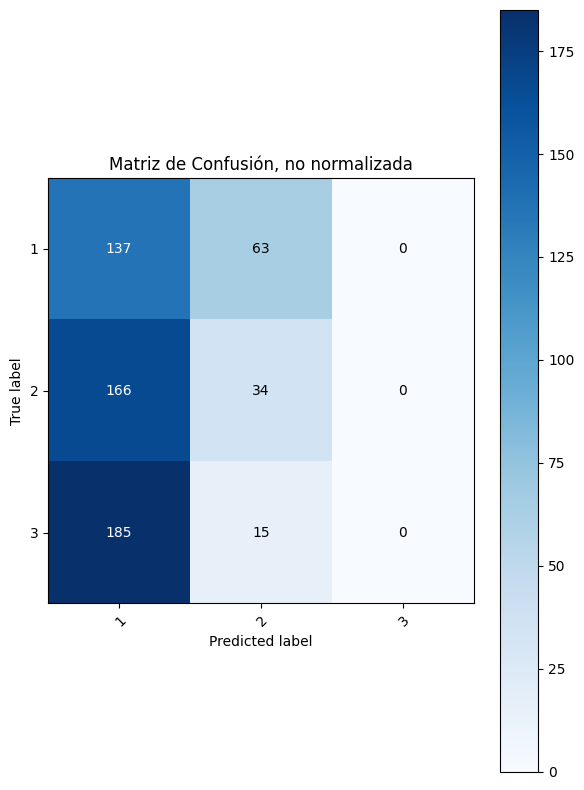

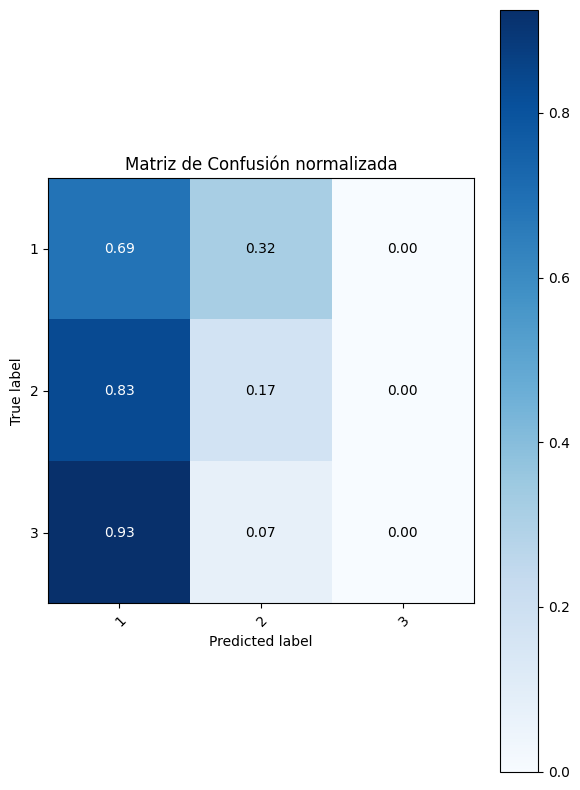

In [ ]:
y_test , pred_val= evaluar_modelo (model_svc)
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

SVC con GridSearch

In [ ]:
parametros = {
    'C'            : [0.5,5,10],
    'kernel'       : ['poly',  'rbf', 'sigmoid'],
    'class_weight' : ['None','balanced'],
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_svc = GridSearchCV(model_svc, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_svc.fit(X_red_val, y_val)

# Obtener mejores parámetros
mejores_params = GS_svc.best_params_
print(mejores_params)

{'C': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [ ]:
model_svc_gs = SVC(max_iter=10000, **mejores_params)
model_svc_gs.fit(X_red_train , y_train)
preds_val = model_svc_gs.predict(X_red_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

F1_score del modelo en validation: 0.43666666666666665


In [ ]:
y_pred= model_svc_gs.predict(X_red_test)
subir_fichero(y_pred,'SVC_GridSearch_RAM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50       202
         2.0       0.37      0.36      0.37       204
         3.0       0.44      0.45      0.45       194

    accuracy                           0.44       600
   macro avg       0.44      0.44      0.44       600
weighted avg       0.44      0.44      0.44       600

Accuracy en validation: 0.43666666666666665
F1_score en validation: 0.43666666666666665
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[100  55  45]
 [ 65  74  61]
 [ 37  75  88]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.5   0.275 0.225]
 [0.325 0.37  0.305]
 [0.185 0.375 0.44 ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

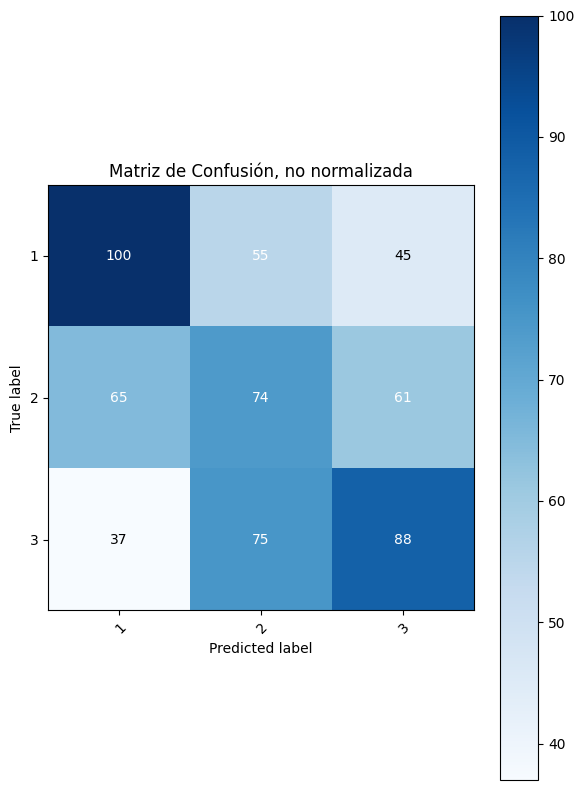

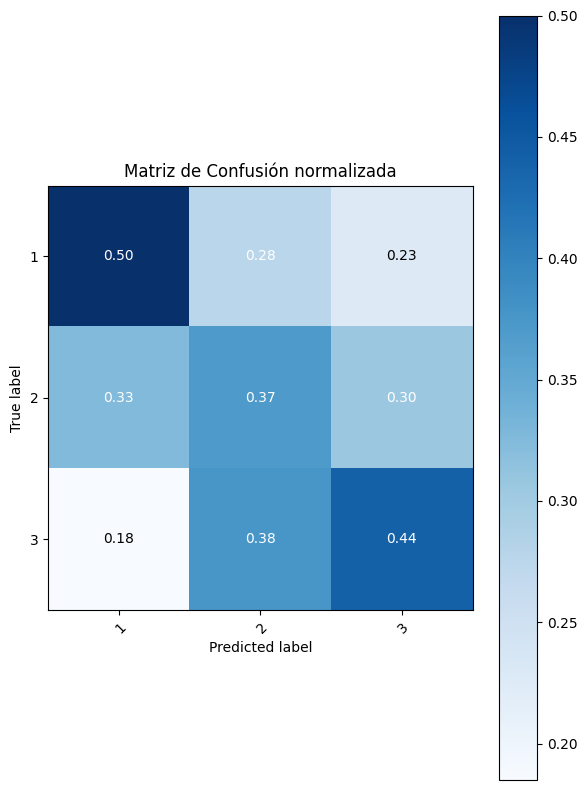

In [ ]:
y_test , pred_val= evaluar_modelo (model_svc_gs)
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

SVC con Random Search

In [ ]:
parametros = {
    'C'            : [0.5,5,10],
    'kernel'       : ['poly',  'rbf', 'sigmoid'],
    'class_weight' : ['None','balanced'],
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
RS_svc = RandomizedSearchCV(model_svc, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_svc.fit(X_red_val, y_val)

# Obtener mejores parámetros
mejores_params = GS_svc.best_params_
print(mejores_params)

{'C': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [ ]:
model_svc_rs = SVC(max_iter=10000, **mejores_params)
model_svc_rs.fit(X_red_train , y_train)
preds_val = model_svc_rs.predict(X_red_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

F1_score del modelo en validation: 0.39372822299651566


# Lazy Predict

In [ ]:
lazy_model = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_model.fit(X_red_train, X_red_val, y_train, y_val)

print(models)

100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.55               0.55    None      0.55   
RandomForestClassifier             0.53               0.53    None      0.52   
ExtraTreesClassifier               0.51               0.51    None      0.50   
LabelPropagation                   0.50               0.50    None      0.50   
BaggingClassifier                  0.50               0.50    None      

# LGBMClassifier

[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

         1.0       0.62      0.63      0.63       198
         2.0       0.45      0.47      0.46       190
         3.0       0.59      0.56      0.58       212

    accuracy                           0.56       600
   macro avg       0.56      0.55      0.55       600
weighted avg       0.56      0.56      0.56       600

Accuracy en validation: 0.555
F1_score en validation: 0.555


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[125  47  28]
 [ 46  89  65]
 [ 27  54 119]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.625 0.235 0.14 ]
 [0.23  0.445 0.325]
 [0.135 0.27  0.595]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

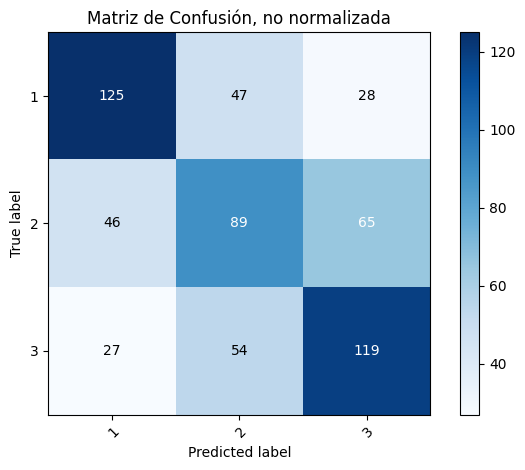

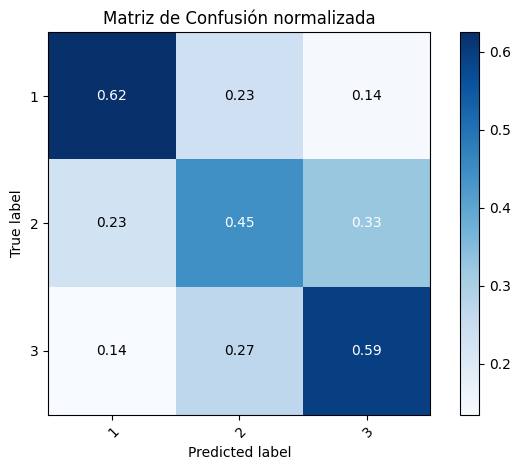

In [26]:
# Crear y entrenar el modelo LGBMClassifier
model_lgbm = lgb.LGBMClassifier(force_col_wise=True)
model_lgbm.fit(X_red_train, y_train)

# Hacer predicciones
y_test, pred_val = evaluar_modelo(model_lgbm)
subir_fichero(y_test,'LGBM_RAM.csv')

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

LGBM con Cross Validation

In [ ]:
cv = KFold(n_splits = 8, shuffle = False) #al poner shuffle =True desordenaba el dataset
cv_f1scores=[]
for cv_train, cv_test in cv.split(X_red_train):
  # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
  cv_train_x = X_red_train.iloc[cv_train]
  cv_train_y = y_train.iloc[cv_train]

  # vamos entrenando los modelos
  model_lgbm.fit(cv_train_x, cv_train_y)

  #guardo el predict de cada modelo
  y_pred = model_lgbm.predict(X_red_train.iloc[cv_test])
  #y_np=np.zeros(len(cv_test))
  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)
#guardo la media de los f1_Scores, para cada split
media_scores=sum(cv_f1scores)/len(cv_f1scores)

#recorro los clasificadores y voy mostrando la precision por cada uno de ellos
print ("F1_Score medio: = %.4f" %  (media_scores ))

[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 4725, number of used features: 4
[LightGBM] [Info] Start training from score -1.111392
[LightGBM] [Info] Start training from score -1.107541
[LightGBM] [Info] Start training from score -1.077255
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 4725, number of used features: 4
[LightGBM] [Info] Start training from score -1.089763
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.107541
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 4725, number of used features: 4
[LightGBM] [Info] Start training from score -1.085367
[LightGBM] [Info] Start training from score -1.104343
[LightGBM] [Info] Start training from score -1.106261
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 4725, number of used features: 4
[LightGBM] [Info] 

***Evaluar y subir fichero***

              precision    recall  f1-score   support

         1.0       0.62      0.62      0.62       199
         2.0       0.40      0.43      0.41       182
         3.0       0.60      0.55      0.57       219

    accuracy                           0.54       600
   macro avg       0.54      0.54      0.54       600
weighted avg       0.54      0.54      0.54       600

Accuracy en validation: 0.5383333333333333
F1_score en validation: 0.5383333333333333


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[124  48  28]
 [ 50  79  71]
 [ 25  55 120]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.62  0.24  0.14 ]
 [0.25  0.395 0.355]
 [0.125 0.275 0.6  ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

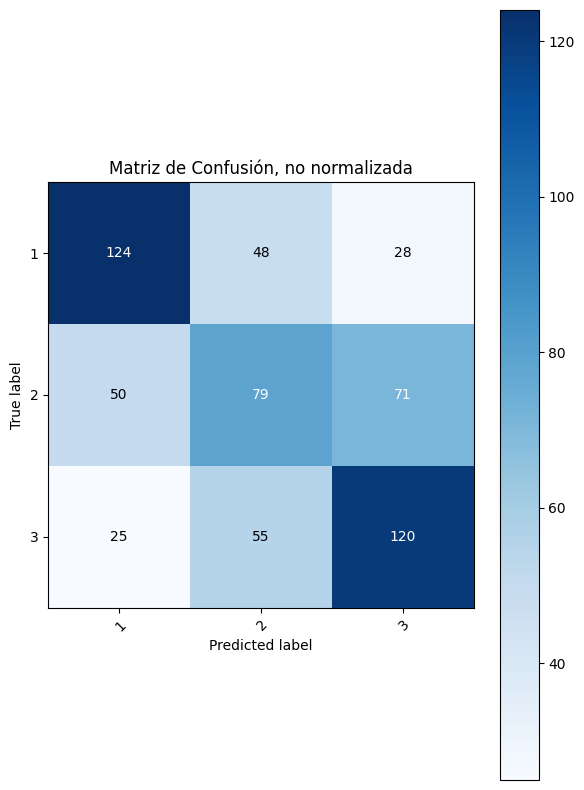

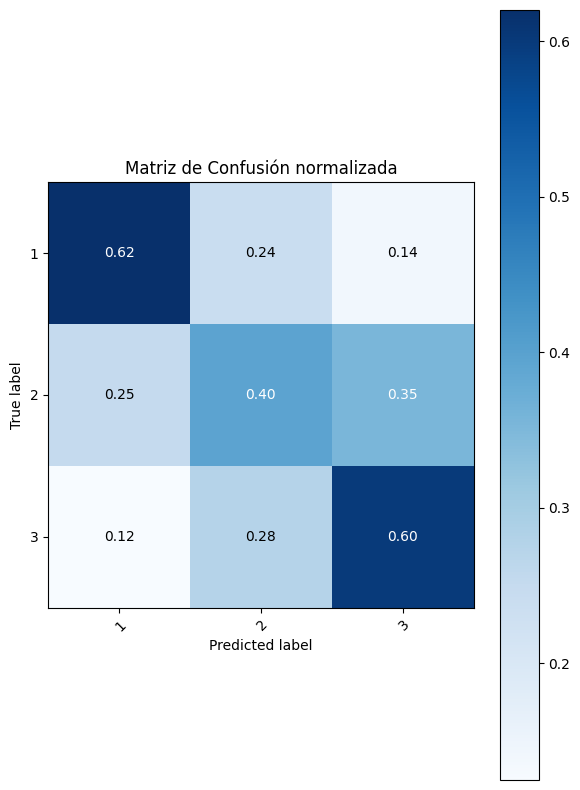

In [ ]:
# Hacer predicciones
y_test, pred_val = evaluar_modelo(model_lgbm)
subir_fichero(y_test,'LGBM_RAM_CV.csv')

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

LGBM con GridSearch

In [28]:
parametros = {
    'num_leaves'      : [100,200],
    'min_data_in_leaf': [500,1000],
    'max_depth'       : [4,8],
    'num_threads'     : [2,4]
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_lgbm = GridSearchCV(model_lgbm, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_lgbm.fit(X_red_train, y_train)

# Obtener mejores parámetros
mejores_params = GS_lgbm.best_params_
print(mejores_params)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [30]:
#evaluar y subir fichero
model_lgbm_gs = lgb.LGBMClassifier(force_col_wise=True,**mejores_params)
model_lgbm_gs.fit(X_red_train , y_train)

# Evaluar modelo y descargar fichero
y_test,pred_val = evaluar_modelo(model_lgbm_gs)
subir_fichero(y_test,'LGBM_GS_RAM.csv')

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[117  45  38]
 [ 50  66  84]
 [ 33  44 123]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.585 0.225 0.19 ]
 [0.25  0.33  0.42 ]
 [0.165 0.22  0.615]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

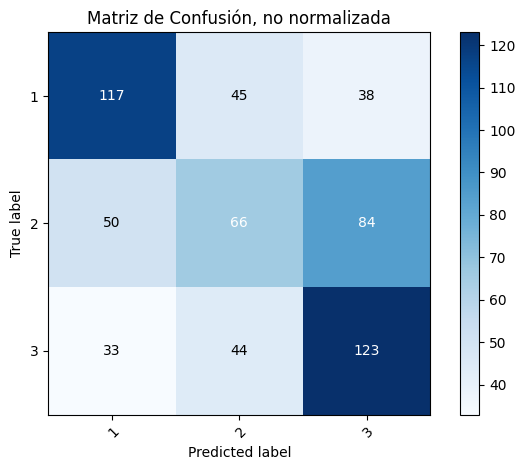

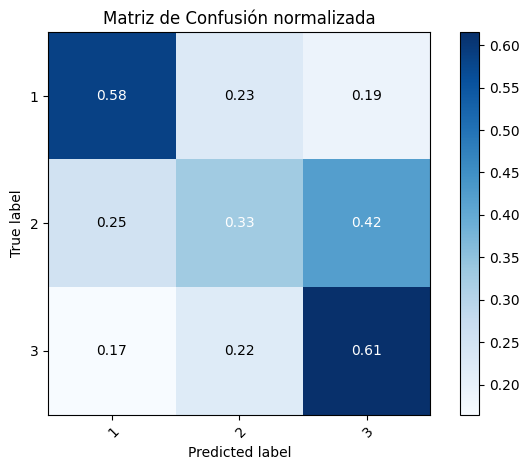

In [31]:
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

LGBM con RandomSearch

In [ ]:
parametros = {
    'num_leaves'      : [10,100,200],
    'min_data_in_leaf': [500,1000,2000],
    'max_depth'       : [4,6,8],
    'num_threads'     : [2,4,8]
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# Random Search
RS_lgbm = RandomizedSearchCV(model_lgbm, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_lgbm.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = RS_lgbm.best_params_
print(mejores_params)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 15494, number of used features: 22
[LightGBM] [Info] Start training from score -1.648530
[LightGBM] [Info] Start training from score -0.372642
[LightGBM] [Info] Start training from score -2.130687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [32]:
#evaluar y subir fichero
mejores_params={'num_threads': 2, 'num_leaves': 100, 'min_data_in_leaf': 500, 'max_depth': 8}
model_lgbm_rs = lgb.LGBMClassifier(force_col_wise=True,**mejores_params)
model_lgbm_rs.fit(X_red_train , y_train)
preds_val = model_lgbm_rs.predict(X_red_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))
# Hacer predicciones
y_test, y_pred = evaluar_modelo(model_lgbm_rs)
subir_fichero(y_test,'LGBM_RS_RAM.csv')

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Extraigo las matrices de confusión para Random Search

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[117  45  38]
 [ 50  66  84]
 [ 33  44 123]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.585 0.225 0.19 ]
 [0.25  0.33  0.42 ]
 [0.165 0.22  0.615]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

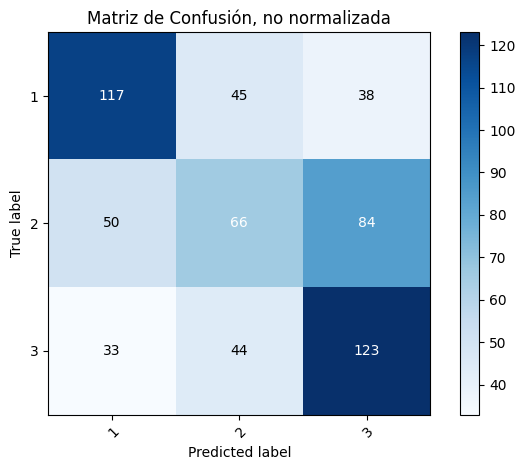

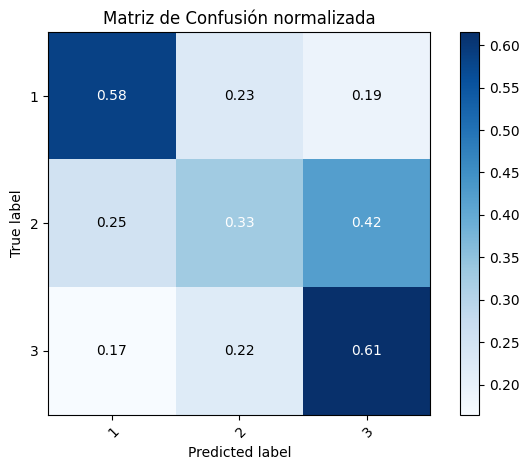

In [33]:
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)